### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from joblib import dump 

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from src.config import CLEAN_TS_DIR

import warnings, math, time, json
# Suppress non-critical warnings (e.g. sklearn feature-name warnings during recursive rollouts).
# Feature order is explicitly controlled and numerical results are unaffected.
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="X does not have valid feature names")

Neben Standardbibliotheken für numerische Berechnungen, Datenmanipulation und Visualisierung (NumPy, pandas, Matplotlib) umfasst dies insbesondere Komponenten aus *scikit-learn* für zeitserienspezifische Validierung, Modelltraining, Hyperparameteroptimierung und Evaluation.

Die Auswahl der Regressionsmodelle (Ridge, Random Forest, HistGradientBoosting) spiegelt bewusst unterschiedliche Modellklassen wider (linear vs. baumbasiert), um strukturelle Unterschiede im Prognoseverhalten untersuchen zu können. Ergänzend werden Hilfsbibliotheken für Pfad- und Zeitstempelmanagement sowie für die Persistierung von Modellen und Metadaten eingebunden.

Warnmeldungen werden gezielt unterdrückt, da im rekursiven Forecasting NumPy-Arrays ohne Feature-Namen an Modelle übergeben werden, die zuvor mit benannten Features trainiert wurden. Die Feature-Reihenfolge ist im gesamten Experiment explizit kontrolliert, sodass diese Warnungen keinen Einfluss auf die numerische Korrektheit oder die Interpretation der Ergebnisse haben. Die Unterdrückung dient ausschließlich der Reduktion nicht-informativer Notebook-Ausgaben.


### Spalten- und Feature-Definitionen

In [3]:
TIMESTAMP_COL = "timestamp"
TARGET = "P_MW"

RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]
TARGET_LAGS = [1, 4, 8, 12, 24, 96]

FOURIER_K = 3
PERIOD_STEPS = 96

MIN_COVERAGE = 0.20

# day-ahead horizon (25h for calculation buffer)
H = 100 

FINAL_HOLDOUT_FRAC = 0.20

OUTER_SPLITS = 3
INNER_SPLITS = 3
N_ITER = 10
RANDOM_STATE = 42
N_JOBS = 1

ORIGIN_STRIDE = 8                # every 2 hours (15min steps)
MAX_TEST_ORIGINS_PER_FOLD = 400  # cap rollouts during model-selection

# Horizon buckets for reporting
H_BUCKETS = [
    (1, 4),
    (5, 12),
    (13, 24),
    (25, 48),
    (49, 100),
]

# Output folder
RUN_TS = datetime.now().strftime("%Y%m%d_%H%M%S")
OUT_DIR = Path("reports") / "forecast_experiments" / RUN_TS
OUT_DIR.mkdir(parents=True, exist_ok=True)

# save wining models
LATEST_DIR = Path("reports") / "forecast_experiments" / "_current"
LATEST_DIR.mkdir(parents=True, exist_ok=True)


In diesem Abschnitt werden die zentralen Steuerparameter des Prognoseexperiments definiert. Projektweite Annahmen wie Zeitauflösung, Zeitzone, Datenverzeichnisse und Bereinigungsstandards sind bereits in der zentralen Konfigurationsdatei (`config.py`) festgelegt und werden hier lediglich referenziert, nicht erneut definiert. Die folgenden Parameter betreffen ausschließlich die Ausgestaltung und Reproduzierbarkeit des konkreten Experiments.

Die Zielgröße der Prognose ist die elektrische Wirkleistung P_MW, die auf einer regularisierten 15-Minuten-Zeitachse modelliert wird. Als exogene Einflussgrößen werden meteorologische Variablen (Windgeschwindigkeit, solare Einstrahlung und Außentemperatur) berücksichtigt. Ergänzend werden autoregressive Lag-Features mit unterschiedlichen zeitlichen Abständen verwendet, um sowohl kurzfristige Dynamiken als auch tagesperiodische Abhängigkeiten der Last abzubilden.

Zur expliziten Modellierung periodischer Strukturen werden Fourier-Komponenten mit einer Tagesperiode von 96 Zeitschritten eingesetzt. Diese Features dienen dazu, wiederkehrende intra-tägliche Muster unabhängig von der absoluten Zeitlage zu erfassen.

Der Prognosehorizont beträgt 100 Zeitschritte und entspricht damit einem Day-Ahead-Szenario von rund 25 Stunden. Die Bewertung der Modelle erfolgt ausschließlich auf dieser Multi-Step-Ebene. Der Datensatz wird zeitlich in einen Trainingsbereich und einen strikt nachgelagerten Holdout-Bereich aufgeteilt, wobei der Holdout-Anteil 20 % der verfügbaren Daten umfasst und ausschließlich für die finale Modellevaluierung genutzt wird.

Die Modellselektion basiert auf einer zeitserienspezifischen, verschachtelten Cross-Validation mit separaten inneren und äußeren Splits. Die äußeren Splits dienen der robusten Bewertung der Day-Ahead-Performance im Trainingszeitraum, während die inneren Splits zur Hyperparameteroptimierung verwendet werden. Zur Begrenzung der Rechenzeit werden Startpunkte für rekursive Rollouts zeitlich ausgedünnt und pro Fold gedeckelt. Diese Einschränkungen stellen einen bewussten Kompromiss zwischen statistischer Stabilität der Fehlerabschätzung und praktischer Durchführbarkeit dar.

Für die Ergebnisdarstellung werden horizontabhängige Fehler zusätzlich in vordefinierten Horizon-Buckets aggregiert. Dies ermöglicht eine kompakte, anwendungsnahe Bewertung der Prognosequalität über unterschiedliche Vorlaufbereiche hinweg.

Alle im Experiment erzeugten Ergebnisse, Modelle und Metadaten werden in einem laufzeitspezifischen Ausgabeverzeichnis abgelegt. Das jeweils beste Modell wird zusätzlich in einem stabilen Zielverzeichnis persistiert, sodass es unabhängig vom Experimentlauf für nachgelagerte Anwendungen verfügbar ist.


### Evaluationsmetriken für Forecast-Qualität

In [4]:
def evaluate(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mae = float(mean_absolute_error(y_true, y_pred))
    rmse = float(math.sqrt(mean_squared_error(y_true, y_pred)))
    r2 = float(r2_score(y_true, y_pred))
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def bucket_means(mae_h, buckets):
    out = {}
    for a, b in buckets:
        # horizons are 1-indexed in naming, but array is 0-indexed
        seg = mae_h[(a-1):b]
        out[f"MAE_h{a:03d}-{b:03d}"] = float(np.nanmean(seg))
    return out

def skill_score(mae_model, mae_baseline):
    return float(1.0 - (mae_model / mae_baseline))

Hier werden drei Hilfsfunktionen für die Auswertung definiert.  
`evaluate()` berechnet die Standardmetriken MAE, RMSE und R² und dient dem direkten Modellvergleich.  
`bucket_means()` fasst horizon-abhängige Fehlerkurven in vordefinierte Bereiche zusammen, um die Interpretation und das Reporting zu vereinfachen.  
`skill_score()` misst die relative Verbesserung gegenüber der Persistence-Baseline, wobei positive Werte auf eine bessere Modellleistung hinweisen.


### Zeit-Features aus dem Timestamp

In [5]:
def add_time_features(df):
    ts = pd.to_datetime(df[TIMESTAMP_COL], utc=True, errors="coerce")
    if ts.isna().any():
        raise ValueError("NaT in timestamp after parsing.")
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month

    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"]  = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"]  = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"]= np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"]= np.cos(2 * np.pi * df["month"] / 12)
    return df

def add_fourier_features(df, period_steps=PERIOD_STEPS, K=FOURIER_K, prefix="day"):
    ts = pd.to_datetime(df[TIMESTAMP_COL], utc=True, errors="coerce")
    if ts.isna().any():
        raise ValueError("NaT in timestamp after parsing.")

    steps_per_hour = period_steps // 24
    minutes_per_step = 60 // steps_per_hour
    step_in_day = (ts.dt.hour * steps_per_hour + (ts.dt.minute // minutes_per_step)).astype(float)

    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_in_day / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_in_day / period_steps)
    return df


def add_target_lags(df, target_col, lags):
    for L in lags:
        df[f"{target_col}_lag{L}"] = df[target_col].shift(L)
    return df

def prepare_df(df_raw):
    df = df_raw.copy()
    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=True, errors="coerce")
    if df[TIMESTAMP_COL].isna().any():
        raise ValueError("NaT in timestamp after parsing.")
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)

    df = add_time_features(df)
    df = add_fourier_features(df)
    df = add_target_lags(df, TARGET, TARGET_LAGS)

    df["target_1"] = df[TARGET].shift(-1)

    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    time_feats = ["hour_sin","hour_cos","dow_sin","dow_cos","month_sin","month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K+1)] + [f"day_cos{k}" for k in range(1, FOURIER_K+1)]
    lag_feats = [f"{TARGET}_lag{L}" for L in TARGET_LAGS]

    exog_cols = present_feats + time_feats + fourier_feats
    lag_cols = lag_feats
    feature_cols = exog_cols + lag_cols

    df_model = df.dropna(subset=feature_cols + ["target_1", TARGET]).copy().reset_index(drop=True)
    return df_model, feature_cols, exog_cols, lag_cols, present_feats

In diesem Block wird das Feature-Engineering für das Forecasting vorbereitet.  
`add_time_features()` ergänzt zyklische Zeitmerkmale (Stunde/Wochentag/Monat) als Sin/Cos, damit Periodizität ohne Sprungstellen modelliert werden kann.  
`add_fourier_features()` bildet zusätzliche tagesperiodische Fourier-Terme, um komplexere Tagesmuster über mehrere Harmonische abzudecken.  
`add_target_lags()` erzeugt verzögerte Zielwerte als autoregressive Features und stellt damit den kurzfristigen Verlauf (z.B. 15 min bis 24 h) explizit bereit.  
`prepare_df()` kombiniert alle Features, erzeugt `target_1` als One-Step-Target und entfernt Zeilen mit fehlenden Feature-/Target-Werten, sodass ein sauberes Supervised-Training-Set entsteht.


### Modell-Definitionen und Hyperparameter-Suchräume


In [6]:
def make_models_and_spaces():
    models = {}

    models["Ridge"] = (
        Pipeline([("scaler", StandardScaler()), ("model", Ridge(random_state=RANDOM_STATE))]),
        {"model__alpha": np.logspace(-3, 3, 20).tolist()},
    )

    models["RF"] = (
        RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS),
        {
            "n_estimators": [200, 400, 800],
            "max_depth": [None, 8, 12, 16, 24],
            "min_samples_leaf": [1, 2, 5, 10],
            "max_features": ["sqrt", 0.5, 0.8, None],
        },
    )

    models["HGB"] = (
        HistGradientBoostingRegressor(random_state=RANDOM_STATE),
        {
            "learning_rate": [0.03, 0.05, 0.08, 0.1],
            "max_depth": [None, 6, 10, 14],
            "max_leaf_nodes": [31, 63, 127],
            "min_samples_leaf": [10, 20, 50],
            "l2_regularization": [0.0, 0.1, 1.0],
        },
    )

    return models

Hier werden die verwendeten Modellklassen samt zugehöriger Hyperparameter-Suchräume definiert.  
Mit Ridge wird ein linearer, stark regularisierbarer Baseline-Kandidat abgedeckt, während Random Forest und HistGradientBoosting nichtlineare Zusammenhänge und Interaktionen modellieren können.  
Die Suchräume sind bewusst begrenzt gewählt, um einen sinnvollen Trade-off zwischen Modellgüte und Rechenaufwand zu gewährleisten.

### Rekursiver Day-Ahead Rollout für Multi-Horizon Forecasts

In [7]:
def _update_lags_from_history(lag_cols, history_values):
    # lag col format: "P_MW_lag96" etc.
    return np.array([history_values[int(col.split("lag")[1])] for col in lag_cols], dtype=float)

def evaluate_day_ahead_recursive(
    model,
    df_model,
    exog_cols,
    lag_cols,
    H=100,
    origin_indices=None,
    origin_stride=1
):
    n = len(df_model)
    max_origin = n - H - 1
    if max_origin <= 0:
        raise ValueError(f"Not enough data for H={H}. n={n}")

    # lags wie "P_MW_lag96" -> 96
    lag_steps = [int(c.split("lag")[1]) for c in lag_cols]
    max_lag = max(lag_steps)

    # Wichtig: j muss mindestens max_lag-1 sein, sonst greift iloc negativ (Leak)
    min_origin = max_lag - 1

    if origin_indices is None:
        origin_indices = np.arange(min_origin, max_origin + 1, origin_stride, dtype=int)
    else:
        origin_indices = np.asarray(origin_indices, dtype=int)
        origin_indices = origin_indices[(origin_indices >= min_origin) & (origin_indices <= max_origin)]

    abs_errors_h = [[] for _ in range(H)]
    sq_errors_h = [[] for _ in range(H)]
    y_true_all, y_pred_all = [], []

    for j in origin_indices:
        # history[L] enthält den Wert y(t-(L-1)); L=1 ist y(t)
        # Wir stellen sicher: alle benötigten Lag-Werte sind vorhanden.
        history = {}
        for L in range(1, max_lag + 1):
            idx = j - (L - 1)
            # idx ist hier garantiert >= 0, weil j >= min_origin
            history[L] = float(df_model[TARGET].iloc[idx])

        # Wenn dennoch was NaN ist (z.B. in TARGET selbst), skip
        if any(np.isnan(history[L]) for L in lag_steps):
            continue

        for k in range(1, H + 1):
            step_idx = j + (k - 1)  # Feature-Zeitpunkt
            exog = (
                df_model.loc[step_idx, exog_cols].astype(float).values
                if exog_cols else np.array([], dtype=float)
            )
            lag_vec = _update_lags_from_history(lag_cols, history)
            x = np.concatenate([exog, lag_vec]).reshape(1, -1)

            y_hat = float(model.predict(x)[0])
            y_true = float(df_model[TARGET].iloc[j + k])

            err = y_true - y_hat
            abs_errors_h[k - 1].append(abs(err))
            sq_errors_h[k - 1].append(err * err)

            y_true_all.append(y_true)
            y_pred_all.append(y_hat)

            # Lags um 1 nach hinten schieben + neue Vorhersage als history[1]
            for L in range(max_lag, 1, -1):
                history[L] = history[L - 1]
            history[1] = y_hat

    mae_h = np.array([np.mean(v) if len(v) else np.nan for v in abs_errors_h], dtype=float)
    rmse_h = np.array([math.sqrt(np.mean(v)) if len(v) else np.nan for v in sq_errors_h], dtype=float)
    overall = evaluate(np.array(y_true_all), np.array(y_pred_all))
    return overall, mae_h, rmse_h


def evaluate_day_ahead_persistence(df_model, H=100, origin_stride=1, min_origin=0):
    n = len(df_model)
    max_origin = n - H - 1
    if max_origin <= 0:
        raise ValueError(f"Not enough data for H={H}. n={n}")

    origin_indices = np.arange(min_origin, max_origin + 1, origin_stride, dtype=int)

    abs_errors_h = [[] for _ in range(H)]
    sq_errors_h = [[] for _ in range(H)]
    y_true_all, y_pred_all = [], []

    for j in origin_indices:
        y0 = float(df_model[TARGET].iloc[j])
        for k in range(1, H + 1):
            y_true = float(df_model[TARGET].iloc[j + k])
            y_hat = y0
            err = y_true - y_hat
            abs_errors_h[k-1].append(abs(err))
            sq_errors_h[k-1].append(err * err)
            y_true_all.append(y_true)
            y_pred_all.append(y_hat)

    mae_h = np.array([np.mean(v) if len(v) else np.nan for v in abs_errors_h], dtype=float)
    rmse_h = np.array([math.sqrt(np.mean(v)) if len(v) else np.nan for v in sq_errors_h], dtype=float)
    overall = evaluate(np.array(y_true_all), np.array(y_pred_all))
    return overall, mae_h, rmse_h


def make_fixed_estimator(model_name: str, params: dict):
    if model_name == "Ridge":
        est = Pipeline([("scaler", StandardScaler()),
                        ("model", Ridge(random_state=RANDOM_STATE))])
        est.set_params(**params)   # expects model__alpha
        return est

    if model_name == "RF":
        est = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS)
        est.set_params(**params)
        return est

    if model_name == "HGB":
        est = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
        est.set_params(**params)
        return est

    raise ValueError(f"Unknown model_name={model_name}")

Diese Funktionen implementieren die Day-Ahead-Evaluierung als **rekursiven Rollout** (Modell sagt Schritt für Schritt voraus und nutzt eigene Vorhersagen als neue Lags) sowie die **Persistence-Baseline** als Referenz.  
Durch `min_origin = max_lag - 1` wird sichergestellt, dass für jede Origin alle benötigten Lag-Werte verfügbar sind und kein ungewollter Lookback über negative Indizes entsteht.  
`make_fixed_estimator` kapselt die saubere Rekonstruktion des finalen Estimators mit fixierten Hyperparametern, sodass das Refit pro Node reproduzierbar und konsistent bleibt.


### Direct Day-Ahead Evaluation über Horizon-Batches

In [8]:
def build_stacked_direct_dataset(df_model, exog_cols, lag_cols, H=100, origin_stride=8):
    n = len(df_model)
    max_origin = n - H - 1
    origins = np.arange(0, max_origin + 1, origin_stride, dtype=int)

    X_rows, y_rows, origin_ids = [], [], []

    for j in origins:
        lag_vec = df_model.loc[j, lag_cols].astype(float).values
        if np.any(np.isnan(lag_vec)):
            continue

        for h in range(1, H + 1):
            tgt_idx = j + h
            exog_vec = df_model.loc[tgt_idx, exog_cols].astype(float).values if exog_cols else np.array([], dtype=float)
            h_feat = np.array([h, h / H], dtype=float)
            X_rows.append(np.concatenate([exog_vec, lag_vec, h_feat]))
            y_rows.append(float(df_model[TARGET].iloc[tgt_idx]))
            origin_ids.append(j)

    Xs = np.asarray(X_rows, dtype=float)
    ys = np.asarray(y_rows, dtype=float)
    origin_ids = np.asarray(origin_ids, dtype=int)
    return Xs, ys, origin_ids

def make_origin_time_cv_splits(origin_ids, n_splits=3):
    """
    Build sklearn-compatible CV splits (train_idx, test_idx) where splits happen on ORIGIN level.
    This avoids leakage in stacked (t,h) rows by ensuring validation origins are strictly later.
    """
    unique_origins = np.unique(origin_ids)
    unique_origins.sort()

    tss = TimeSeriesSplit(n_splits=n_splits)
    splits = []
    for tr_o_idx, te_o_idx in tss.split(unique_origins):
        tr_origins = set(unique_origins[tr_o_idx])
        te_origins = set(unique_origins[te_o_idx])

        tr_idx = np.where(np.isin(origin_ids, list(tr_origins)))[0]
        te_idx = np.where(np.isin(origin_ids, list(te_origins)))[0]
        splits.append((tr_idx, te_idx))
    return splits

def evaluate_day_ahead_direct(model, df_model, exog_cols, lag_cols, H=100, origin_stride=8):
    n = len(df_model)
    max_origin = n - H - 1
    origin_indices = np.arange(0, max_origin + 1, origin_stride, dtype=int)

    abs_errors_h = [[] for _ in range(H)]
    sq_errors_h = [[] for _ in range(H)]
    y_true_all, y_pred_all = [], []

    for j in origin_indices:
        lag_vec = df_model.loc[j, lag_cols].astype(float).values
        if np.any(np.isnan(lag_vec)):
            continue

        X_batch, y_true_batch = [], []
        for h in range(1, H + 1):
            tgt_idx = j + h
            exog_vec = df_model.loc[tgt_idx, exog_cols].astype(float).values if exog_cols else np.array([], dtype=float)
            h_feat = np.array([h, h / H], dtype=float)
            X_batch.append(np.concatenate([exog_vec, lag_vec, h_feat]))
            y_true_batch.append(float(df_model[TARGET].iloc[tgt_idx]))

        X_batch = np.asarray(X_batch, dtype=float)
        y_true_batch = np.asarray(y_true_batch, dtype=float)

        y_hat_batch = model.predict(X_batch).astype(float)

        for h in range(1, H + 1):
            err = y_true_batch[h-1] - y_hat_batch[h-1]
            abs_errors_h[h-1].append(abs(err))
            sq_errors_h[h-1].append(err * err)
            y_true_all.append(y_true_batch[h-1])
            y_pred_all.append(y_hat_batch[h-1])

    mae_h = np.array([np.mean(v) if len(v) else np.nan for v in abs_errors_h], dtype=float)
    rmse_h = np.array([math.sqrt(np.mean(v)) if len(v) else np.nan for v in sq_errors_h], dtype=float)
    overall = evaluate(np.array(y_true_all), np.array(y_pred_all))
    return overall, mae_h, rmse_h


Diese Funktionen setzen den **Direct-Multi-Horizon-Ansatz (stacked)** um: Für jede Origin werden Trainingszeilen für alle Horizonte `h=1..H` erzeugt, wobei `h` und `h/H` als explizite Features die Horizontabhängigkeit modellieren.  
Die Cross-Validation wird korrekt **auf Origin-Ebene** gesplittet (`make_origin_time_cv_splits`), damit keine Leakage entsteht (sonst könnten Zeilen desselben Origins in Train und Val landen).  
`evaluate_day_ahead_direct` bewertet dann den Direct-Ansatz horizonweise und aggregiert zusätzlich einen Gesamt-Score, ohne rekursiv eigene Vorhersagen in die Lags zurückzuführen (Lags bleiben “fix” aus der Origin).


### Auswahl eines exemplarischen Knoten 

In [9]:
meas_dir = Path(CLEAN_TS_DIR)
files = sorted(meas_dir.glob("*_hist_clean.csv"))
assert files, f"Keine *_hist_clean.csv in {meas_dir}"

rows = []
for p in files:
    node_id = p.stem.replace("_hist_clean", "")
    df = pd.read_csv(p, parse_dates=[TIMESTAMP_COL]).sort_values(TIMESTAMP_COL)
    if TARGET not in df.columns:
        continue
    s = df[TARGET].astype(float)

    coverage = 1.0 - s.isna().mean()
    if coverage < MIN_COVERAGE:
        continue

    med = float(s.median(skipna=True))
    rows.append({
        "node_id": node_id,
        "coverage": float(coverage),
        "mean": float(s.mean(skipna=True)),
        "median": med,
        "abs_median": abs(med),
        "p95": float(s.quantile(0.95)),
        "std": float(s.std(skipna=True)),
        "n_raw": int(len(s)),
    })

stats = pd.DataFrame(rows)
assert not stats.empty, "Nach Coverage-Filter keine Nodes übrig. MIN_COVERAGE senken."

stats = stats.sort_values("abs_median").reset_index(drop=True)
high_node = stats.iloc[-1]["node_id"]

print("Auswahlkriterium: MAX abs(median(P_MW)) mit MIN_COVERAGE", MIN_COVERAGE)
print("HIGH node:", high_node)
print("HIGH node stats:")
display(stats[stats["node_id"] == high_node])

stats.to_csv(OUT_DIR / "node_stats.csv", index=False)


Auswahlkriterium: MAX abs(median(P_MW)) mit MIN_COVERAGE 0.2
HIGH node: SHUW_E24
HIGH node stats:


,node_id,coverage,mean,median,abs_median,p95,std,n_raw
13,SHUW_E24,0.971001,-39.504793,-32.915148,32.915148,-3.475897,28.834975,72036


In diesem Schritt werden alle verfügbaren Nodes anhand ihrer historischen Zeitreihen statistisch charakterisiert und vorgefiltert.  
Nodes mit unzureichender Datenabdeckung werden ausgeschlossen, um instabile Modellschätzungen zu vermeiden.  
Als Referenz-Node für das Modell-Tuning wird anschließend der Node mit dem größten absoluten Median der Wirkleistung gewählt, da hier die stärkste und zugleich stabile Lastprägung vorliegt.


### Laden der High-Node Zeitreihe und Erstellung des Supervised Learning-Datensatzes

In [10]:
path = meas_dir / f"{high_node}_hist_clean.csv"
df_raw = pd.read_csv(path)

df_model, feature_cols, exog_cols, lag_cols, present_feats = prepare_df(df_raw)

print(f"\nPrepared supervised base for {high_node}: n={len(df_model)}")
print("Exog present:", present_feats)
print("Feature cols:", len(feature_cols), "(exog/time/fourier:", len(exog_cols), ", lags:", len(lag_cols), ")")
assert len(df_model) > (H + 500), f"Time series too short for H={H}. n={len(df_model)}"



Prepared supervised base for SHUW_E24: n=69274
Exog present: ['wind_speed_mps', 'solar_radiation_Wm2', 'temperature_C']
Feature cols: 21 (exog/time/fourier: 15 , lags: 6 )


Hier wird die Zeitreihe des ausgewählten High-Nodes in ein überwachtes Lernproblem überführt.  
Die Feature-Matrix umfasst Wetter-Exogenen, zyklische Zeit-/Fourier-Features zur Abbildung von Tages-/Wochen-/Saisonalität sowie Target-Lags für Autokorrelation.  
Mit `n=69.274` verbleiben nach dem Drop von NaNs ausreichend viele Trainingspunkte. Die Mindestlänge-Prüfung stellt sicher, dass die Day-Ahead-Evaluation mit `H=100` und ausreichendem Puffer sinnvoll möglich ist.


### Train/Holdout Split für finale Day-Ahead Bewertung

In [11]:
n = len(df_model)
split_idx = int((1.0 - FINAL_HOLDOUT_FRAC) * n)

holdout_start = split_idx
holdout_max_origin_global = n - H - 1
if holdout_start > holdout_max_origin_global:
    raise ValueError("Holdout window too small for day-ahead evaluation. Reduce FINAL_HOLDOUT_FRAC or H.")

df_train_full = df_model.iloc[:split_idx].reset_index(drop=True)
df_hold = df_model.iloc[holdout_start:].reset_index(drop=True)

print(f"\nFinal split: train [0:{split_idx}) | holdout [{split_idx}:{n})")
print(f"Holdout length: {len(df_hold)} | allowed max origin in holdout-only frame: {len(df_hold) - H - 1}")



Final split: train [0:55419) | holdout [55419:69274)
Holdout length: 13855 | allowed max origin in holdout-only frame: 13754


Die Zeitreihe wird strikt zeitlich in Trainings- und Holdout-Bereich getrennt (80 % / 20 %).  
Der zusätzliche Check stellt sicher, dass das Holdout-Fenster lang genug ist, um eine Day-Ahead-Evaluation über den vollständigen Horizont `H=100` ohne Indexüberläufe durchzuführen.  
Mit über 13.000 Holdout-Punkten und ausreichend gültigen Origins ist eine stabile und aussagekräftige Out-of-Sample-Bewertung gewährleistet.


### Persistence-Baseline auf dem Holdout-Set für Day-Ahead Forecasts


In [12]:
baseline_overall, baseline_mae_h, baseline_rmse_h = evaluate_day_ahead_persistence(
    df_model=df_hold,
    H=H,
    origin_stride=ORIGIN_STRIDE,
    min_origin=0
)

Als Referenz wird eine Persistence-Baseline berechnet, bei der der letzte beobachtete Wert unverändert in die Zukunft fortgeschrieben wird.  
Diese Baseline definiert das minimale Leistungsniveau für alle weiteren Modelle und dient später als Bezugspunkt für Skill-Scores über alle Horizonte.  
Die horizonweise Berechnung (`MAE(h)`) ermöglicht einen direkten Vergleich der Fehlerentwicklung mit zunehmender Vorhersageweite.


### Modellselektion mit Nested TimeSeriesSplit und Day-Ahead Backtesting auf Outer-Folds


In [13]:
models = make_models_and_spaces()

X_train_full = df_train_full[feature_cols].astype(float).reset_index(drop=True)
y_train_full = df_train_full["target_1"].astype(float).reset_index(drop=True)

outer = TimeSeriesSplit(n_splits=OUTER_SPLITS)
cv_rows = []
fold_skips = []

print("\n" + "="*90)
print("MODEL SELECTION (TRAIN): tune one-step, evaluate day-ahead recursive on outer folds")
print("="*90)

for model_name, (estimator, param_dist) in models.items():
    fold_scores = []
    fold_fit_secs = []
    used_folds = 0

    for fold_i, (tr_idx, te_idx) in enumerate(outer.split(X_train_full), start=1):
        X_tr, y_tr = X_train_full.iloc[tr_idx], y_train_full.iloc[tr_idx]

        inner = TimeSeriesSplit(n_splits=INNER_SPLITS)
        search = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=param_dist,
            n_iter=N_ITER,
            scoring="neg_mean_absolute_error",
            cv=inner,
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS,
            verbose=0,
        )

        t0 = time.time()
        search.fit(X_tr, y_tr)
        fit_s = time.time() - t0

        best = search.best_estimator_

        # Fold dataframe: concatenate train+test portion (for recursion start), then restrict origins to test-only
        df_fold = df_train_full.iloc[np.r_[tr_idx, te_idx]].reset_index(drop=True)
        test_start = len(tr_idx)
        test_end = len(tr_idx) + len(te_idx) - 1

        max_origin = len(df_fold) - H - 1

        lag_steps = [int(c.split("lag")[1]) for c in lag_cols]
        min_origin = max(lag_steps) - 1

        origin_start = max(test_start, min_origin)
        origin_end = min(max_origin, test_end - H)


        if origin_end < origin_start:
            fold_skips.append({"model": model_name, "outer_fold": fold_i, "reason": "test_window_too_short_for_H_or_lags"})
            continue

        origins = np.arange(origin_start, origin_end + 1, ORIGIN_STRIDE, dtype=int)
        if MAX_TEST_ORIGINS_PER_FOLD is not None and len(origins) > MAX_TEST_ORIGINS_PER_FOLD:
            origins = origins[:MAX_TEST_ORIGINS_PER_FOLD]

        overall, mae_h, rmse_h = evaluate_day_ahead_recursive(
            model=best,
            df_model=df_fold,
            exog_cols=exog_cols,
            lag_cols=lag_cols,
            H=H,
            origin_indices=origins,
            origin_stride=ORIGIN_STRIDE
        )

        used_folds += 1
        fold_scores.append(overall)
        fold_fit_secs.append(fit_s)

        cv_rows.append({
            "model": model_name,
            "outer_fold": fold_i,
            "dayahead_MAE": overall["MAE"],
            "dayahead_RMSE": overall["RMSE"],
            "dayahead_R2": overall["R2"],
            "fit_seconds": float(fit_s),
            "best_params": str(search.best_params_),
            "n_test_origins": int(len(origins)),
        })

    # Mean summary row (only over used folds)
    if used_folds > 0:
        cv_rows.append({
            "model": model_name,
            "outer_fold": "MEAN",
            "dayahead_MAE": float(np.mean([s["MAE"] for s in fold_scores])),
            "dayahead_RMSE": float(np.mean([s["RMSE"] for s in fold_scores])),
            "dayahead_R2": float(np.mean([s["R2"] for s in fold_scores])),
            "fit_seconds": float(np.mean(fold_fit_secs)) if fold_fit_secs else np.nan,
            "best_params": "(varies per fold)",
            "n_test_origins": int(np.mean([r["n_test_origins"] for r in cv_rows if r["model"] == model_name and r["outer_fold"] != "MEAN"])) if any((r["model"] == model_name and r["outer_fold"] != "MEAN") for r in cv_rows) else 0,
            "used_folds": int(used_folds),
        })

cv_df = pd.DataFrame(cv_rows)
print("\nOuter-fold day-ahead results (TRAIN backtest):")
display(cv_df)

if fold_skips:
    skip_df = pd.DataFrame(fold_skips)
    print("\nSkipped folds (info):")
    display(skip_df)
    skip_df.to_csv(OUT_DIR / "model_selection_skipped_folds.csv", index=False)

mean_df = cv_df[cv_df["outer_fold"].astype(str) == "MEAN"].sort_values("dayahead_MAE")
print("\nModel ranking by day-ahead MAE (lower is better):")
display(mean_df[["model","dayahead_MAE","dayahead_RMSE","dayahead_R2","fit_seconds","used_folds"]])

best_model_name = mean_df.iloc[0]["model"]
print("\nSelected BEST model by day-ahead MAE:", best_model_name)

cv_df.to_csv(OUT_DIR / "model_selection_outer_results.csv", index=False)


MODEL SELECTION (TRAIN): tune one-step, evaluate day-ahead recursive on outer folds

Outer-fold day-ahead results (TRAIN backtest):


,model,outer_fold,dayahead_MAE,dayahead_RMSE,dayahead_R2,fit_seconds,best_params,n_test_origins,used_folds
0,Ridge,1,12.511229,16.412295,0.464824,0.124220,{'model__alpha': 0.001},400,NaN
1,Ridge,2,16.227798,21.417221,0.343367,0.158250,{'model__alpha': 0.001},400,NaN
2,Ridge,3,16.118247,22.043380,0.231152,0.199273,{'model__alpha': 0.001},400,NaN
3,Ridge,MEAN,14.952425,19.957632,0.346448,0.160581,(varies per fold),400,3.0
4,RF,1,15.894294,20.199291,0.189355,333.884173,"{'n_estimators': 200, 'min_samples_leaf': 10, ...",400,NaN
5,RF,2,18.064599,24.311728,0.153888,758.337439,"{'n_estimators': 200, 'min_samples_leaf': 10, ...",400,NaN
6,RF,3,17.707735,24.570052,0.044796,1173.694840,"{'n_estimators': 200, 'min_samples_leaf': 10, ...",400,NaN
7,RF,MEAN,17.222209,23.027024,0.129346,755.305484,(varies per fold),400,3.0
8,HGB,1,16.270658,20.258935,0.184561,31.298071,"{'min_samples_leaf': 20, 'max_leaf_nodes': 31,...",400,NaN
9,HGB,2,17.533551,22.394751,0.282059,28.186148,"{'min_samples_leaf': 10, 'max_leaf_nodes': 31,...",400,NaN



Model ranking by day-ahead MAE (lower is better):


,model,dayahead_MAE,dayahead_RMSE,dayahead_R2,fit_seconds,used_folds
3,Ridge,14.952425,19.957632,0.346448,0.160581,3.0
11,HGB,16.814121,21.735055,0.220640,28.901788,3.0
7,RF,17.222209,23.027024,0.129346,755.305484,3.0



Selected BEST model by day-ahead MAE: Ridge


Hier wird ein verschachteltes Time-Series-CV Setup genutzt: innen werden Hyperparameter auf One-Step-MAE getuned, außen wird die Qualität jedoch als echte Day-Ahead-Recursive Prognose gemessen. Dadurch wird die Modellauswahl an dem bewertet, was später wirklich relevant ist (Rollout über H Schritte), und nicht nur am einfachen One-Step-Fehler.

In den Ergebnissen ist Ridge vorn: niedrigste mittlere Day-Ahead-MAE (≈ 14.95) bei sehr kurzer Trainingszeit pro Fold (< 0.2s). RF und HGB sind deutlich langsamer (RF extrem) und liefern hier trotzdem schlechtere Day-Ahead-MAEs, was gegen unnötige Modellkomplexität in diesem Setup spricht.

### Finale Holdout-Evaluation für Recursive Day-Ahead Forecasts mit Hyperparameter-Tuning


In [14]:
final_rows = []
final_curves = {}  
final_params = {}

print("\n" + "="*90)
print("FINAL HOLDOUT EVALUATION (DAY-AHEAD, RECURSIVE)")
print("="*90)

for model_name, (estimator, param_dist) in models.items():
    inner = TimeSeriesSplit(n_splits=INNER_SPLITS)
    search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        n_iter=max(25, N_ITER),
        scoring="neg_mean_absolute_error",
        cv=inner,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        verbose=0,
    )

    t0 = time.time()
    search.fit(X_train_full, y_train_full)
    fit_s = time.time() - t0

    best = search.best_estimator_
    final_params[f"recursive_{model_name}"] = search.best_params_

    overall, mae_h, rmse_h = evaluate_day_ahead_recursive(
        model=best,
        df_model=df_hold,
        exog_cols=exog_cols,
        lag_cols=lag_cols,
        H=H,
        origin_indices=None,
        origin_stride=ORIGIN_STRIDE
    )

    final_curves[f"Recursive_{model_name}"] = mae_h

    row = {
        "node": high_node,
        "approach": "Recursive",
        "model": model_name,
        "MAE": overall["MAE"],
        "RMSE": overall["RMSE"],
        "R2": overall["R2"],
        "Skill_vs_Persistence": skill_score(overall["MAE"], baseline_overall["MAE"]),
        "fit_seconds": float(fit_s),
        "best_params": str(search.best_params_),
        **bucket_means(mae_h, H_BUCKETS),
    }
    final_rows.append(row)

final_df = pd.DataFrame(final_rows).sort_values("MAE")
print("\nFinal holdout (recursive) — sorted by MAE:")
display(final_df)

best_recursive_row = final_df.iloc[0].to_dict()  # best by MAE on holdout recursive
final_df.to_csv(OUT_DIR / "final_holdout_recursive_results.csv", index=False)



FINAL HOLDOUT EVALUATION (DAY-AHEAD, RECURSIVE)

Final holdout (recursive) — sorted by MAE:


,node,approach,model,MAE,RMSE,R2,Skill_vs_Persistence,fit_seconds,best_params,MAE_h001-004,MAE_h005-012,MAE_h013-024,MAE_h025-048,MAE_h049-100
0,SHUW_E24,Recursive,Ridge,14.880954,19.814450,0.503494,0.287143,0.540364,{'model__alpha': 26.366508987303554},6.064475,11.434793,14.842179,15.741688,15.701010
2,SHUW_E24,Recursive,HGB,15.741023,21.296822,0.426425,0.245942,60.009283,"{'min_samples_leaf': 20, 'max_leaf_nodes': 31,...",5.763144,10.782529,14.262102,16.177490,17.411240
1,SHUW_E24,Recursive,RF,16.243143,21.894684,0.393769,0.221888,4442.662324,"{'n_estimators': 200, 'min_samples_leaf': 5, '...",5.722501,10.978179,14.794310,16.948384,17.871269


Hier wird das endgültige Tuning auf dem kompletten Trainingsfenster durchgeführt und anschließend die Day-Ahead-Qualität ausschließlich auf dem Holdout gemessen. Damit ist die Tabelle die relevante Aussage für die erwartete Performance „im Einsatz“ (ohne Datenleck aus dem Holdout).

Ridge bleibt bestes rekursives Modell auf dem Holdout (MAE ≈ 14.88) und schlägt die Persistence-Baseline deutlich (Skill ≈ 0.29). Die Bucket-Werte zeigen das typische Muster: sehr gute Kurzfrist-Horizonte (h001–004 ≈ 6.06), anschließend steigt der Fehler mit dem Horizont und stabilisiert sich grob im Bereich ~15–16 MW.

HGB ist nah dran, aber schlechter (MAE ≈ 15.74) und deutlich teurer in der Laufzeit (~60 s). RF ist am schwächsten (MAE ≈ 16.24) und extrem langsam (~4443 s), was ihn für regelmäßige Re-Trainings/Experimente praktisch unattraktiv macht.


### Direct Multi-Horizon Training und Global-Winner-Export


In [ ]:
print("\n" + "="*90)
print(f"DIRECT MULTI-HORIZON (STACKED) for BEST model: {best_model_name}")
print("="*90)

if best_model_name == "Ridge":
    direct_estimator = Pipeline([("scaler", StandardScaler()), ("model", Ridge(random_state=RANDOM_STATE))])
    direct_space = {"model__alpha": np.logspace(-3, 3, 20).tolist()}
elif best_model_name == "RF":
    direct_estimator = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS)
    direct_space = {
        "n_estimators": [200, 400],
        "max_depth": [None, 12, 24],
        "min_samples_leaf": [1, 5],
        "max_features": ["sqrt", 0.8],
    }
else:
    direct_estimator = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
    direct_space = {
        "learning_rate": [0.03, 0.05, 0.08, 0.1],
        "max_depth": [None, 6, 10, 14],
        "max_leaf_nodes": [31, 63, 127],
        "min_samples_leaf": [10, 20, 50],
        "l2_regularization": [0.0, 0.1, 1.0],
    }

# build stacked dataset from TRAIN
X_direct, y_direct, origin_ids = build_stacked_direct_dataset(
    df_model=df_train_full,
    exog_cols=exog_cols,
    lag_cols=lag_cols,
    H=H,
    origin_stride=ORIGIN_STRIDE
)

print(f"Direct stacked training set: X={X_direct.shape}, y={y_direct.shape}, unique_origins={len(np.unique(origin_ids))}")

direct_cv_splits = make_origin_time_cv_splits(origin_ids, n_splits=INNER_SPLITS)

direct_search = RandomizedSearchCV(
    estimator=direct_estimator,
    param_distributions=direct_space,
    n_iter=max(25, N_ITER),
    scoring="neg_mean_absolute_error",
    cv=direct_cv_splits,           
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    verbose=0,
)

t0 = time.time()
direct_search.fit(X_direct, y_direct)
direct_fit_s = time.time() - t0

direct_best = direct_search.best_estimator_
final_params["direct_best_model"] = best_model_name
final_params[f"direct_{best_model_name}"] = direct_search.best_params_

direct_overall, direct_mae_h, direct_rmse_h = evaluate_day_ahead_direct(
    model=direct_best,
    df_model=df_hold,
    exog_cols=exog_cols,
    lag_cols=lag_cols,
    H=H,
    origin_stride=ORIGIN_STRIDE
)

dump(
    direct_best, 
    OUT_DIR / f"final_model_direct_{best_model_name.lower()}.joblib"
)


final_curves[f"DirectStacked_{best_model_name}"] = direct_mae_h

direct_summary = {
    "node": high_node,
    "approach": "DirectStacked",
    "model": best_model_name,
    "MAE": direct_overall["MAE"],
    "RMSE": direct_overall["RMSE"],
    "R2": direct_overall["R2"],
    "Skill_vs_Persistence": skill_score(direct_overall["MAE"], baseline_overall["MAE"]),
    "fit_seconds": float(direct_fit_s),
    "best_params": str(direct_search.best_params_),
    **bucket_means(direct_mae_h, H_BUCKETS),
}

GLOBAL_DIR = Path("reports") / "forecast_experiments" / "_global_winner"
GLOBAL_DIR.mkdir(parents=True, exist_ok=True)

global_winner = {
    "winner_approach": "DirectStacked",
    "winner_model_name": str(best_model_name),
    "winner_params": {k: (v.item() if hasattr(v, "item") else v) for k, v in direct_search.best_params_.items()},
    "H": int(H),
    "timestamp_col": TIMESTAMP_COL,
    "target_col": TARGET,
    "raw_features": RAW_FEATURES,
    "target_lags": TARGET_LAGS,
    "fourier_k": FOURIER_K,
    "period_steps": PERIOD_STEPS,
    "direct_h_features": ["h", "h_over_H"],
    "note": f"Winner tuned on high_node={high_node}. Refit per node with fixed params.",
}

(GLOBAL_DIR / "winner_config.json").write_text(
    json.dumps(global_winner, indent=2),
    encoding="utf-8"
)
print("Saved global winner config to:", (GLOBAL_DIR / "winner_config.json").resolve())


baseline_summary = {
    "node": high_node,
    "approach": "Baseline",
    "model": "Persistence",
    "MAE": baseline_overall["MAE"],
    "RMSE": baseline_overall["RMSE"],
    "R2": baseline_overall["R2"],
    "Skill_vs_Persistence": 0.0,
    "fit_seconds": 0.0,
    "best_params": "-",
    **bucket_means(baseline_mae_h, H_BUCKETS),
}


DIRECT MULTI-HORIZON (STACKED) for BEST model: Ridge
Direct stacked training set: X=(691500, 23), y=(691500,), unique_origins=6915
Saved global winner config to: /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/reports/forecast_experiments/_global_winner/winner_config.json


Hier wird aus dem One-Step-Winner (Ridge) ein echtes Multi-Horizon-Modell gebaut, indem ein „stacked“ Trainingssatz erzeugt wird: pro Origin werden alle Horizonte h=1…H als eigene Zeilen erstellt. Dadurch lernt das Modell die Horizont-Abhängigkeit explizit über die Zusatzfeatures `h` und `h/H` (statt Fehler über rekursive Rollouts zu akkumulieren).

Die CV-Splits laufen origin-basiert (`make_origin_time_cv_splits`), wodurch Leakage zwischen (t,h)-Zeilen vermieden wird. Das ist entscheidend, weil sonst „spätere“ Origins indirekt im Training landen könnten.

Am Ende wird der globale Winner als `winner_config.json` persistiert. Diese Datei ist die zentrale Schnittstelle für den späteren Refit pro Node mit fixierten Hyperparametern; dadurch bleibt Training/Inference reproduzierbar und entkoppelt vom Notebook.


### Finale Modellvergleichsübersicht

In [16]:
final_compare = pd.DataFrame(
    [baseline_summary]
    + final_rows
    + [direct_summary]
).sort_values(["MAE","RMSE"])

print("\n" + "="*90)
print("FINAL COMPARISON (HOLDOUT, DAY-AHEAD H=100)")
print("="*90)
display(final_compare)

final_compare.to_csv(OUT_DIR / "final_comparison.csv", index=False)


FINAL COMPARISON (HOLDOUT, DAY-AHEAD H=100)


,node,approach,model,MAE,RMSE,R2,Skill_vs_Persistence,fit_seconds,best_params,MAE_h001-004,MAE_h005-012,MAE_h013-024,MAE_h025-048,MAE_h049-100
4,SHUW_E24,DirectStacked,Ridge,12.681607,16.920419,0.636885,0.392500,5.802203,{'model__alpha': 1000.0},12.005863,12.285363,12.490648,12.659051,12.849026
1,SHUW_E24,Recursive,Ridge,14.880954,19.814450,0.503494,0.287143,0.540364,{'model__alpha': 26.366508987303554},6.064475,11.434793,14.842179,15.741688,15.701010
3,SHUW_E24,Recursive,HGB,15.741023,21.296822,0.426425,0.245942,60.009283,"{'min_samples_leaf': 20, 'max_leaf_nodes': 31,...",5.763144,10.782529,14.262102,16.177490,17.411240
2,SHUW_E24,Recursive,RF,16.243143,21.894684,0.393769,0.221888,4442.662324,"{'n_estimators': 200, 'min_samples_leaf': 5, '...",5.722501,10.978179,14.794310,16.948384,17.871269
0,SHUW_E24,Baseline,Persistence,20.875083,28.520403,-0.031651,0.000000,0.000000,-,5.012234,10.317967,15.290118,20.500841,25.181039


Die finale Vergleichstabelle fasst Baseline, rekursive Modelle und das Direct-Stacked-Modell auf demselben Holdout (H=100) zusammen und sortiert nach MAE/RMSE.

Das DirectStacked-Ridge ist hier klar am stärksten: niedrigster MAE (12.68), höchstes R² (0.64) und bester Skill vs. Persistence (~0.39). Auffällig ist außerdem die sehr gleichmäßige MAE-Kurve über alle Horizon-Buckets (≈12.0–12.85), d. h. die Qualität bricht über den Vorhersagehorizont kaum ein.

Die rekursiven Modelle sind schwächer, was typisch ist (Fehler akkumulieren im Rollout). Ridge-Recursive ist dabei der beste rekursive Ansatz, während RF extrem teuer ist (sehr hohe fit_seconds) bei gleichzeitig schlechterer Güte.

Die Persistence-Baseline ist erwartbar deutlich schlechter (MAE 20.88, negatives R²), liefert aber eine sinnvolle Referenz zur Einordnung der Skill-Scores.


### Speichern von Ergebnis-Kurven und Run-Konfiguration


In [17]:
# Save curves to CSV (h, each curve)
curves_df = pd.DataFrame({"h": np.arange(1, H+1)})
curves_df["Baseline_Persistence"] = baseline_mae_h
for name, curve in final_curves.items():
    curves_df[name] = curve
curves_df.to_csv(OUT_DIR / "mae_by_horizon_curves.csv", index=False)

# Save run config & params
run_config = {
    "high_node": high_node,
    "n_df_model": int(len(df_model)),
    "n_train": int(len(df_train_full)),
    "n_holdout": int(len(df_hold)),
    "H": H,
    "FINAL_HOLDOUT_FRAC": FINAL_HOLDOUT_FRAC,
    "OUTER_SPLITS": OUTER_SPLITS,
    "INNER_SPLITS": INNER_SPLITS,
    "N_ITER": N_ITER,
    "ORIGIN_STRIDE": ORIGIN_STRIDE,
    "MAX_TEST_ORIGINS_PER_FOLD": MAX_TEST_ORIGINS_PER_FOLD,
    "feature_cols": feature_cols,
    "exog_cols": exog_cols,
    "lag_cols": lag_cols,
    "present_exog": present_feats,
    "h_buckets": H_BUCKETS,
}
with open(OUT_DIR / "run_config.json", "w") as f:
    json.dump(run_config, f, indent=2)

with open(OUT_DIR / "best_params.json", "w") as f:
    json.dump(final_params, f, indent=2)

print(f"\nSaved artifacts to: {OUT_DIR.resolve()}")



Saved artifacts to: /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/reports/forecast_experiments/20260124_183220


Die MAE-Kurven pro Horizont werden explizit als CSV persistiert, sodass der Fehlerverlauf über den gesamten Prognosehorizont unabhängig von Plots reproduzierbar analysiert werden kann.

Zusätzlich wird die vollständige Run-Konfiguration (Datenumfang, Splits, Horizon, Feature-Definitionen) sowie alle selektierten Hyperparameter gespeichert. Damit ist der gesamte Experimentlauf eindeutig nachvollziehbar und reproduzierbar, auch ohne Zugriff auf das Notebook selbst.

Der timestamp-basierte Output-Ordner stellt sicher, dass verschiedene Experimente sauber getrennt bleiben und keine Ergebnisse überschrieben werden.


### Visualisierung der MAE über den Prognosehorizont


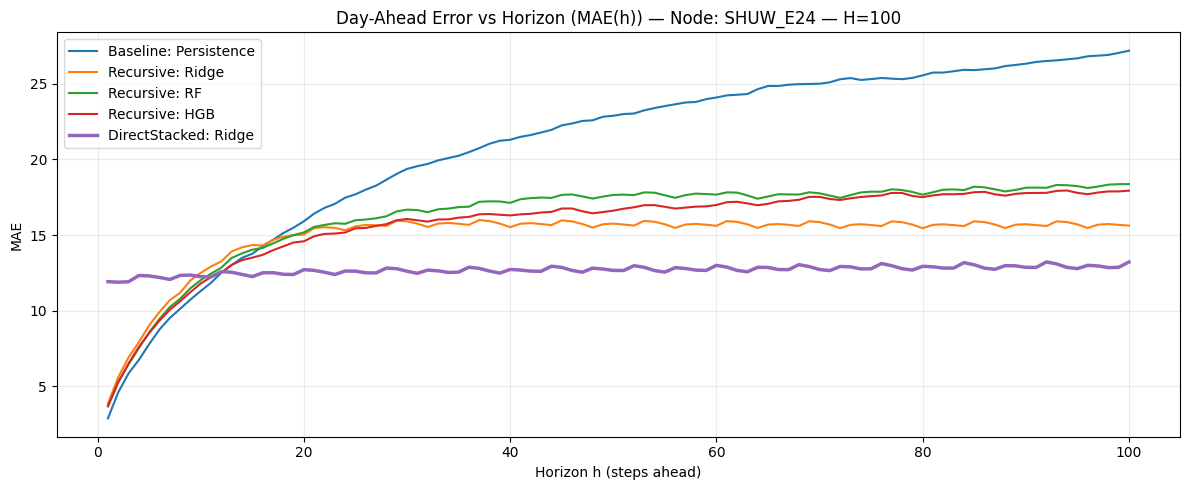

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(np.arange(1, H+1), baseline_mae_h, label="Baseline: Persistence")

for r in final_rows:
    key = f"Recursive_{r['model']}"
    plt.plot(np.arange(1, H+1), final_curves[key], label=f"Recursive: {r['model']}")

plt.plot(np.arange(1, H+1), direct_mae_h, linewidth=2.5, label=f"DirectStacked: {best_model_name}")

plt.title(f"Day-Ahead Error vs Horizon (MAE(h)) — Node: {high_node} — H={H}")
plt.xlabel("Horizon h (steps ahead)")
plt.ylabel("MAE")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


Die Grafik zeigt deutlich den strukturellen Unterschied zwischen rekursiven und direkten Multi-Horizon-Ansätzen.  
Die Persistence-Baseline verschlechtert sich kontinuierlich mit wachsendem Horizont und dient als klare Untergrenze.

Die rekursiven Modelle (Ridge, RF, HGB) zeigen den erwarteten Fehleranstieg durch Fehlerakkumulation; Ridge ist dabei konsistent besser als RF und HGB, bleibt aber deutlich hinter dem direkten Ansatz zurück.

Das DirectStacked-Ridge-Modell weist über den gesamten Horizont hinweg einen nahezu konstanten MAE auf. Dies bestätigt, dass die direkte Modellierung jedes Horizonts die Langfriststabilität erheblich verbessert und insbesondere für größere Vorhersagehorizonte klar überlegen ist.


### Zusammenfassung der besten Modelle und Holdout-Ergebnisse


In [19]:

print("\nBest model (TRAIN ranking):", best_model_name)
print("Baseline (holdout):", baseline_overall)
print("DirectStacked (holdout):", {k: direct_summary[k] for k in ["MAE","RMSE","R2","Skill_vs_Persistence"]})



Best model (TRAIN ranking): Ridge
Baseline (holdout): {'MAE': 20.87508326784697, 'RMSE': 28.520402839994347, 'R2': -0.03165080586041236}
DirectStacked (holdout): {'MAE': 12.681606962732253, 'RMSE': 16.920419250174362, 'R2': 0.6368854510515705, 'Skill_vs_Persistence': 0.39250029329151426}


Das Trainings-Backtesting identifiziert Ridge konsistent als bestes Modell, was sich auch auf dem unabhängigen Holdout bestätigt.

Gegenüber der Persistence-Baseline reduziert das DirectStacked-Ridge den MAE deutlich (20.88 → 12.68) und erreicht ein klar positives R² von 0.64, während die Baseline sogar negativ ist. Der Skill-Score von ca. 0.39 zeigt eine substanzielle Verbesserung gegenüber dem naiven Ansatz.

Damit bestätigt sich, dass die im Training getroffene Modellwahl nicht nur lokal optimal ist, sondern auch auf dem Holdout robust generalisiert.


### Per-Node Refit mit fixierten Winner-Hyperparametern und optionaler Holdout-Evaluation

In [20]:
REFIT_DIR = Path("reports") / "forecast_models_per_node_fixedhp"
REFIT_DIR.mkdir(parents=True, exist_ok=True)

winner_model = str(best_model_name)
winner_params = {k: (v.item() if hasattr(v, "item") else v) for k, v in direct_search.best_params_.items()}
winner_cfg_path = GLOBAL_DIR / "winner_config.json"

# Optional: speed-up eval
DO_EVAL = True
EVAL_ORIGIN_STRIDE = max(ORIGIN_STRIDE, 16)  
MAX_NODES_EVAL = None  # e.g. 10 to eval only first 10 nodes

refit_rows = []
eval_count = 0

for p in files:
    node_id = p.stem.replace("_hist_clean", "")
    try:
        df_raw_n = pd.read_csv(p, parse_dates=[TIMESTAMP_COL])

        df_model_n, feature_cols_n, exog_cols_n, lag_cols_n, present_feats_n = prepare_df(df_raw_n)

        if len(df_model_n) <= (H + 500):
            refit_rows.append({"node_id": node_id, "ok": False, "reason": "too_short", "n": int(len(df_model_n))})
            continue

        n_n = len(df_model_n)
        split_idx_n = int((1.0 - FINAL_HOLDOUT_FRAC) * n_n)
        df_train_n = df_model_n.iloc[:split_idx_n].reset_index(drop=True)
        df_hold_n  = df_model_n.iloc[split_idx_n:].reset_index(drop=True)

        X_direct_n, y_direct_n, origin_ids_n = build_stacked_direct_dataset(
            df_model=df_train_n,
            exog_cols=exog_cols_n,
            lag_cols=lag_cols_n,
            H=H,
            origin_stride=ORIGIN_STRIDE
        )

        if len(y_direct_n) == 0:
            refit_rows.append({"node_id": node_id, "ok": False, "reason": "no_stacked_rows", "n": int(len(df_model_n))})
            continue

        est = make_fixed_estimator(winner_model, winner_params)
        est.fit(X_direct_n, y_direct_n)

        node_dir = REFIT_DIR / node_id
        node_dir.mkdir(parents=True, exist_ok=True)
        dump(est, node_dir / "model.joblib")

        meta = {
            "node_id": node_id,
            "winner_config": str(winner_cfg_path.resolve()),
            "winner_approach": "DirectStacked",
            "winner_model_name": winner_model,
            "winner_params": winner_params,
            "H": int(H),
            "timestamp_col": TIMESTAMP_COL,
            "target_col": TARGET,
            "raw_features": RAW_FEATURES,
            "target_lags": TARGET_LAGS,
            "fourier_k": FOURIER_K,
            "period_steps": PERIOD_STEPS,
            "exog_cols": exog_cols_n,
            "lag_cols": lag_cols_n,
            "present_exog": present_feats_n,
            "train_rows": int(len(df_train_n)),
            "holdout_rows": int(len(df_hold_n)),
            "p_pos_hist": float((df_model_n[TARGET] > 0).mean()),
            "median_hist": float(df_model_n[TARGET].median()),
        }

        overall = None
        if DO_EVAL and (MAX_NODES_EVAL is None or eval_count < MAX_NODES_EVAL):
            overall, _, _ = evaluate_day_ahead_direct(
                model=est,
                df_model=df_hold_n,
                exog_cols=exog_cols_n,
                lag_cols=lag_cols_n,
                H=H,
                origin_stride=EVAL_ORIGIN_STRIDE
            )
            meta["holdout_overall"] = overall
            eval_count += 1

        (node_dir / "meta.json").write_text(json.dumps(meta, indent=2), encoding="utf-8")

        refit_rows.append({
            "node_id": node_id,
            "ok": True,
            "MAE": overall["MAE"] if overall else np.nan,
            "p_pos_hist": meta["p_pos_hist"],
        })

    except Exception as e:
        refit_rows.append({"node_id": node_id, "ok": False, "reason": type(e).__name__})

refit_df = pd.DataFrame(refit_rows).sort_values(["ok", "MAE"], ascending=[False, True])
display(refit_df)
refit_df.to_csv(REFIT_DIR / "refit_summary.csv", index=False)

print("Saved per-node models to:", REFIT_DIR.resolve())


,node_id,ok,MAE,p_pos_hist
8,SIES_E02,True,1.860816,0.141765
5,JUBO_E03,True,2.405021,0.078822
0,BOLN_E01,True,2.640537,0.186410
9,SIEV_E01,True,3.966376,0.476635
4,JUBO_E02,True,5.409306,0.132398
2,BOLN_E03,True,6.010254,0.159127
3,JUBO_E01,True,6.919165,0.947459
11,TARP_E03,True,7.943394,0.521128
1,BOLN_E02,True,8.001449,0.864822
10,TARP_E01,True,8.223103,0.960417


Saved per-node models to: /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/reports/forecast_models_per_node_fixedhp


Hier wird das zuvor gefundene „Winner“-Setup (DirectStacked + feste Hyperparameter aus `winner_config.json`) für **jede Node separat neu trainiert** und als `model.joblib` gespeichert. Dadurch erhält jede Node ein eigenes Modell, aber alle basieren auf derselben, vorher ausgewählten Modellklasse und denselben Hyperparametern.

Die Holdout-Auswertung ist in diesem Block **optional** und dient nur als Plausibilitätscheck bzw. Monitoring: mit `DO_EVAL=True` wird pro Node zusätzlich ein Day-Ahead-Direct MAE auf dem Holdout berechnet (hier beschleunigt über `EVAL_ORIGIN_STRIDE >= 16`). Wird `DO_EVAL=False`, werden die Modelle trotzdem trainiert und gespeichert, nur ohne MAE/`holdout_overall`.

Die Tabelle zeigt, dass das Refit technisch für alle gelisteten Nodes erfolgreich war (`ok=True`). Die MAE-Werte sind **node-spezifisch** und deshalb direkt nur eingeschränkt vergleichbar; auffällig ist aber, dass die „High“-Node (SHUW_E24) im Vergleich deutlich höhere Fehler aufweist, was zur höheren Last-/Dynamik-Komplexität dieser Node passt.


---

### Fazit

In dieser Arbeit wurde ein konsistenter Forecasting-Workflow für Day-Ahead-Prognosen entwickelt, der von der Feature-Generierung über eine saubere zeitliche Validierung bis hin zur automatisierten Modellauswahl reicht. Der Vergleich zeigt, dass direkte Multi-Horizon-Modelle (DirectStacked) rekursiven Ansätzen und der Persistence-Baseline überlegen sind, insbesondere für längere Prognosehorizonte.

Das ausgewählte DirectStacked-Ridge-Modell generalisiert stabil auf dem Holdout und liefert über alle Horizonte hinweg gleichmäßige Fehler. Durch das anschließende Refit mit fixierten Hyperparametern konnte dieses Setup zuverlässig auf alle Nodes übertragen und produktionsnah persistiert werden.

Damit liegt ein reproduzierbares, skalierbares und methodisch sauberes Vorgehen vor, das sowohl für die Bewertung einzelner Nodes als auch als Grundlage für den späteren operativen Einsatz geeignet ist.
